# $\mathrm{HONO}$

In [1]:
using Plots, MLPlotRecipes
using HDF5
using Tables, DataFrames, CSV
using MLJ, MLJGaussianProcesses
using StatsBase 

using KernelFunctions
using ParameterHandling

In [2]:
include("./utils.jl")

predict_logσ_wΔ

# Loading Data

In [3]:
h5_path = "../../data/photolysis_data.h5" 
species = "HONO" 
nice_name = "HONO"

λs, σs, T1s, T2s, source_idx, T_units, category, formula, λ_units, σ_units = get_raw_data(h5_path, species)

println("max λ: ", maximum(λs))
println("min λ: ", minimum(λs))

max λ: 403.93913
min λ: 184.0


In [4]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 

In [5]:
Δλ = 50 # nm for padding
df = data_to_df(λs, σs, T1s, T2s, source_idx; λ_lb=minimum(hr4000_df.λ)-Δλ, λ_ub=maximum(hr4000_df.λ)+Δλ)
# df = data_to_df(λs, σs, T1s, T2s, source_idx; λ_lb=0.0, λ_ub=1200.0)
println(nrow(df))
describe(df)

10544


4×7 DataFrame
 Row │ variable   mean           min           median         max         nmis ⋯
     │ Symbol     Float64        Real          Float64        Real        Int6 ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ λ          347.453        184.0         349.651        401.423          ⋯
   2 │ σ            9.53908e-20    6.5563e-24    6.51245e-20    4.25e-18
   3 │ T          297.984        295.0         298.0          300.0
   4 │ source_id   16.7276         1            22.0           28
                                                               2 columns omitted

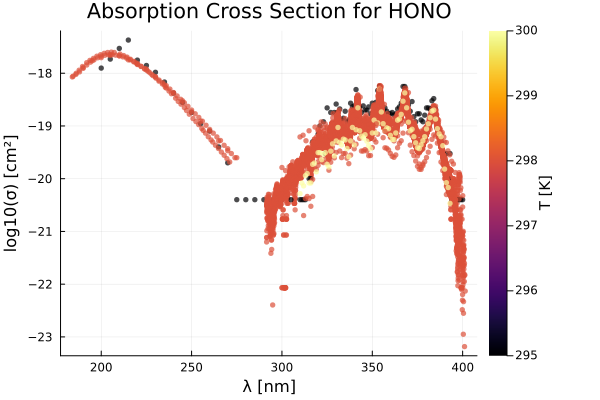

In [6]:
nskip = 1

p2 = scatter(
    df.λ[1:nskip:end],
    log10.(df.σ[1:nskip:end]),
    zcolor=df.T[1:nskip:end],
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Absorption Cross Section for $(nice_name)",
    label="",
)

savefig("O3_p2.png")

display(p2)

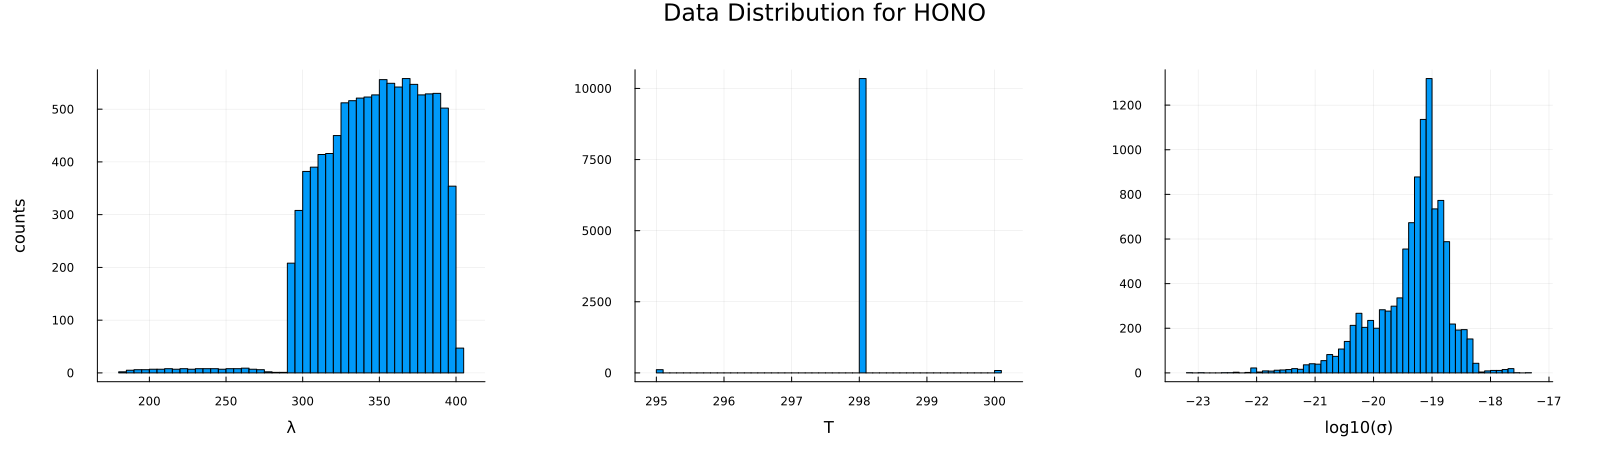

In [7]:
p1 = histogram(df.λ, xlabel="λ", ylabel="counts", label="",)
p2 = histogram(df.T, xlabel="T", label="",)
p3 = histogram(log10.(df.σ), xlabel="log10(σ)", label="",)
#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450),  margin=10Plots.mm, plot_title="Data Distribution for $(nice_name)")

In [8]:
# load in spectrometer wavelengths
hr4000_df = CSV.File("../hr4000_wavelengths.txt") |> DataFrame ; 

# Data Preprocessing

In [9]:
# deal with identical wavelength records 

gdfs = groupby(df, :T)

res_dfs = []

for gdf ∈ gdfs
    gdf_by_λ = groupby(gdf, :λ)
    push!(res_dfs, combine(gdf_by_λ, [:σ, :T] .=> mean, renamecols = false))
end

df_unique = vcat(res_dfs...)

8955×3 DataFrame
  Row │ λ        σ          T       
      │ Float64  Float64    Float64 
──────┼─────────────────────────────
    1 │   200.0  1.25e-18     295.0
    2 │   205.0  1.85e-18     295.0
    3 │   210.0  2.95e-18     295.0
    4 │   215.0  4.25e-18     295.0
    5 │   220.0  1.77e-18     295.0
    6 │   225.0  1.4e-18      295.0
    7 │   230.0  1.04e-18     295.0
    8 │   235.0  6.8e-19      295.0
    9 │   240.0  4.2e-19      295.0
   10 │   245.0  2.8e-19      295.0
   11 │   250.0  1.8e-19      295.0
  ⋮   │    ⋮         ⋮         ⋮
 8946 │   384.0  1.993e-19    300.0
 8947 │   385.0  1.351e-19    300.0
 8948 │   386.0  8.87e-20     300.0
 8949 │   387.0  7.09e-20     300.0
 8950 │   388.0  6.25e-20     300.0
 8951 │   389.0  4.22e-20     300.0
 8952 │   390.0  1.52e-20     300.0
 8953 │   391.0  8.4e-21      300.0
 8954 │   392.0  6.8e-21      300.0
 8955 │   393.0  3.4e-21      300.0
                   8934 rows omitted

In [10]:
# here is where we would do representative subsampling if there are too many records (> 2000) 
λ_idxs = representative_rand_sample(df_unique.λ, 500, 1500)
T_idxs = representative_rand_sample(df_unique.λ, 5, 1000)
σ_idxs = representative_rand_sample(log10.(df_unique.σ), 500, 2000) 



idxs_res = shuffle(unique(vcat(λ_idxs, T_idxs, σ_idxs)))


df_sampled = df_unique[idxs_res, :]


max_data_λ = maximum(df_sampled.λ)
min_data_λ = minimum(df_sampled.λ)

println(nrow(df_sampled))
describe(df_sampled)

1879


3×7 DataFrame
 Row │ variable  mean          min           median       max         nmissing ⋯
     │ Symbol    Float64       Float64       Float64      Float64     Int64    ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ λ         338.796       184.0         341.852      401.423            0 ⋯
   2 │ σ           1.2597e-19    6.5563e-24    4.075e-20    4.25e-18         0
   3 │ T         297.971       295.0         298.0        300.0              0
                                                                1 column omitted

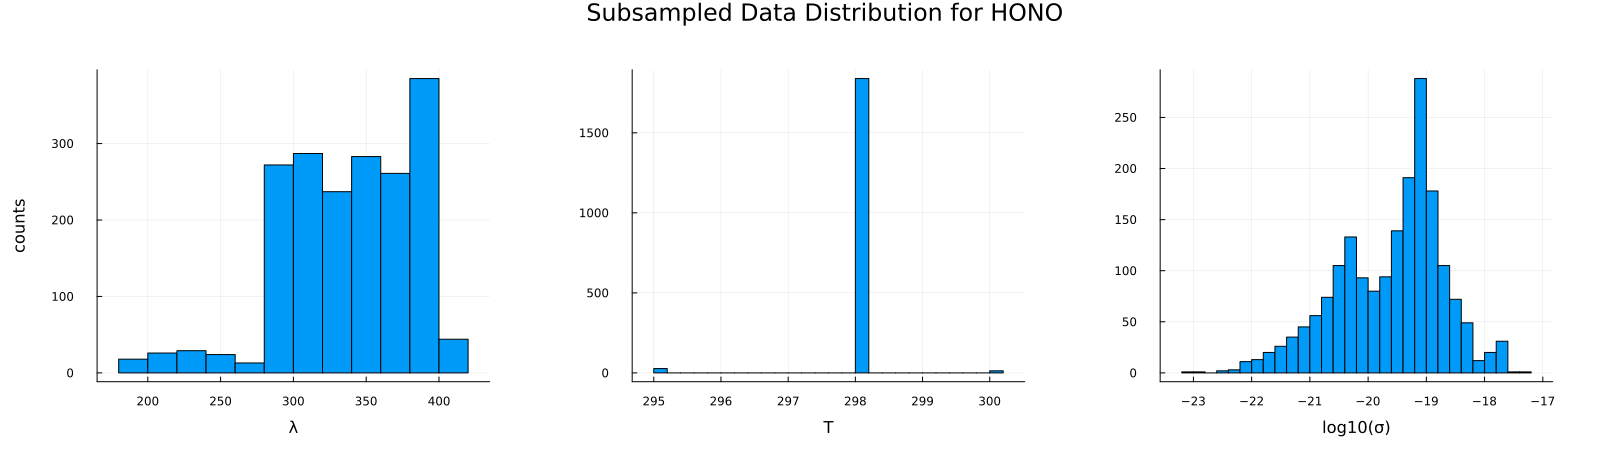

In [11]:
p1 = histogram(df_sampled.λ, xlabel="λ", ylabel="counts", label="", margin=10Plots.mm)
p2 = histogram(df_sampled.T, xlabel="T", label="", margin=10Plots.mm)
p3 = histogram(log10.(df_sampled.σ), xlabel="log10(σ)", label="", margin=10Plots.mm)
#p3 = histogram(df.σ, xlabel="σ", ylabel="counts")

phist = plot(p1, p2, p3, layout=(1,3), size=(1600, 450), plot_title="Subsampled Data Distribution for $(nice_name)")

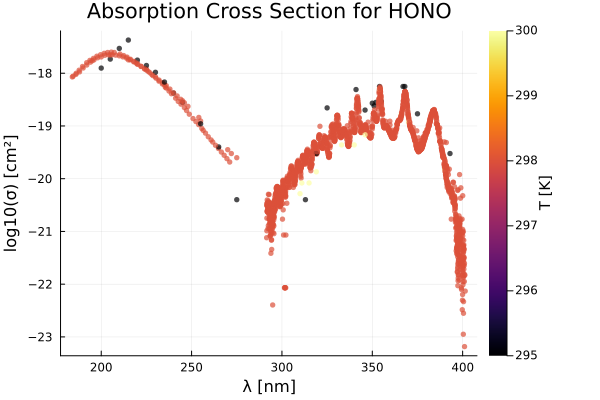

In [12]:
# visualize pre-processed data: 
p = scatter(
    df_sampled.λ,
    log10.(df_sampled.σ),
    zcolor=df_sampled.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Absorption Cross Section for $(nice_name)",
    label="",
)

# GPR Fit

In [13]:
train_frac = 0.95
ntrain = trunc(Int, train_frac * nrow(df_sampled))
println(ntrain)

1785


In [14]:
idxs = shuffle(1:nrow(df_sampled))
idxs_train = idxs[1:ntrain]
idxs_test = idxs[ntrain+1:end]

Xtrain = df_sampled[idxs_train, [:λ, :T]]
Xtest = df_sampled[idxs_test, [:λ, :T]]

ytrain = log10.(df_sampled.σ[idxs_train])
ytest = log10.(df_sampled.σ[idxs_test])

94-element Vector{Float64}:
 -21.08578910859862
 -19.643821114446624
 -19.278354233710253
 -20.25313237214957
 -20.114734923502898
 -20.16192577723122
 -19.27945207355842
 -19.230334716946757
 -20.69574650313373
 -18.923068425444345
 -18.024568191490737
 -21.132438238632812
 -19.094468553283004
   ⋮
 -19.450212281708723
 -21.082820202130673
 -18.8457586698327
 -19.690454996704563
 -18.84016220892889
 -18.568636235841012
 -19.76738501686522
 -18.537602002101043
 -19.212986093534838
 -19.21925796402699
 -19.010777178311574
 -19.11715683071615

In [15]:
# compute length scales
κ = 1
ℓ_λ = std(Xtrain.λ)/κ
ℓ_T = std(Xtrain.T)/κ

# compute variance parameters
SNR = 5 
σf² = var(ytrain)
σₙ² = (sqrt(σf²)/SNR)^2

# set up initial values list
θ_init = (σf²=positive(σf²), ℓ_λ=positive(ℓ_λ), ℓ_T=positive(ℓ_T))


function mykernel(θ::NamedTuple)
    return θ.σf² * with_lengthscale(SqExponentialKernel(), [θ.ℓ_λ, θ.ℓ_T])
end

mykernel (generic function with 1 method)

In [16]:
μ_init = -30.0
gpr = GPR(
    μ=μ_init,
    k=mykernel,
    θ_init=θ_init,
    σ²=σₙ²,
)


GPR(
  μ = -30.0, 
  k = mykernel, 
  θ_init = (σf² = ParameterHandling.Positive{Float64, typeof(exp), Float64}(-0.1664520797142161, exp, 1.4901161193847656e-8), ℓ_λ = ParameterHandling.Positive{Float64, typeof(exp), Float64}(3.810052200157765, exp, 1.4901161193847656e-8), ℓ_T = ParameterHandling.Positive{Float64, typeof(exp), Float64}(-0.9337318304001542, exp, 1.4901161193847656e-8)), 
  σ² = 0.033866536128641114, 
  optimizer = Optim.LBFGS{Nothing, LineSearches.InitialStatic{Float64}, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}, Optim.var"#19#21"}(10, LineSearches.InitialStatic{Float64}
  alpha: Float64 1.0
  scaled: Bool false
, LineSearches.HagerZhang{Float64, Base.RefValue{Bool}}
  delta: Float64 0.1
  sigma: Float64 0.9
  alphamax: Float64 Inf
  rho: Float64 5.0
  epsilon: Float64 1.0e-6
  gamma: Float64 0.66
  linesearchmax: Int64 50
  psi3: Float64 0.1
  display: Int64 0
  mayterminate: Base.RefValue{Bool}
, nothing, Optim.var"#19#21"(), Optim.Flat(), true))

In [17]:
mach = machine(gpr, Xtrain, ytrain) |> fit!

[ Info: Training machine(GPR(μ = -30.0, …), …).


Iter     Function value   Gradient norm 
     0     1.487104e+03     1.309465e+03
 * time: 0.036767005920410156
     1     1.384439e+03     6.650121e+02
 * time: 8.936930894851685
     2     4.232223e+02     1.746167e+02
 * time: 10.585679054260254
     3     3.839587e+02     9.041691e+01
 * time: 11.692155838012695
     4     3.391744e+02     9.821894e+01
 * time: 13.942743062973022
     5     1.671821e+02     7.720536e+01
 * time: 15.585248947143555
     6     8.969387e+01     5.106306e+01
 * time: 17.276231050491333
     7     8.488883e+01     4.060513e+01
 * time: 18.905810832977295
     8     8.436795e+01     3.657852e+01
 * time: 20.575065851211548
     9     8.376085e+01     2.340805e+01
 * time: 21.676629066467285
    10     8.318824e+01     6.713038e+00
 * time: 22.772039890289307
    11     8.306272e+01     1.737051e+00
 * time: 24.399945974349976
    12     8.306071e+01     2.008461e-01
 * time: 25.51724100112915
    13     8.306064e+01     2.536711e-03
 * time: 27.209326028

trained Machine; caches model-specific representations of data
  model: GPR(μ = -30.0, …)
  args: 
    1:	Source @664 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @390 ⏎ AbstractVector{Continuous}


# Model Evaluation

In [18]:
rpt = report(mach)

(summary = "L-BFGS",
 minimizer = [3.972459243621209, 1.635777491743218, 4.472602338324171, -3.1170177272006563],
 minimum = -3.872179053998252,
 iterations = 589,
 converged = false,)

In [19]:
y_pred_train = predict_mean(mach, Xtrain);
y_pred_test = predict_mean(mach, Xtest);

┌ Warning: Keyword argument `orientation` is deprecated.
│ Please use `permute` instead.
└ @ Plots ~/.julia/packages/Plots/io9zQ/src/args.jl:1548


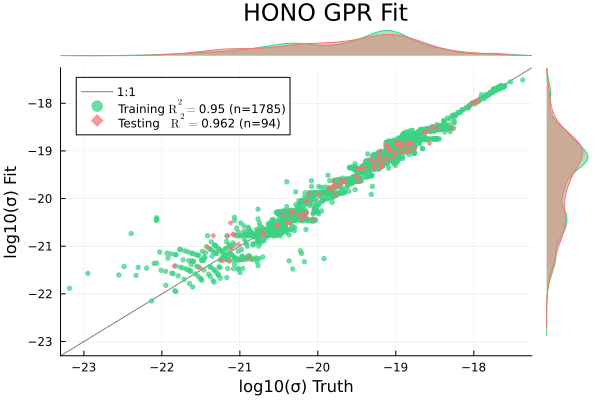

In [20]:
p = scatterresult(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    plot_title="$(nice_name) GPR Fit"
)

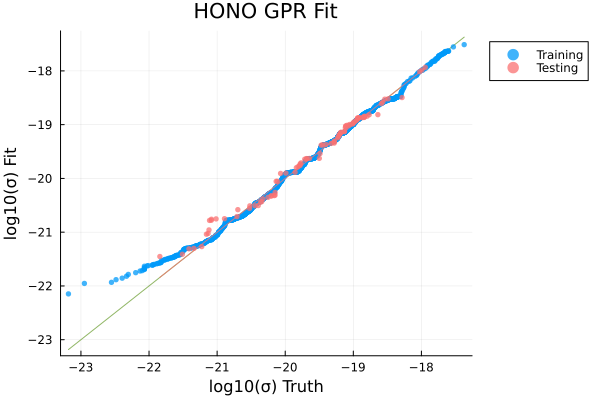

In [21]:
p = quantilequantile(
    ytrain, y_pred_train,
    ytest, y_pred_test,
    xlabel="log10(σ) Truth",
    ylabel="log10(σ) Fit",
    title="$(nice_name) GPR Fit"
)


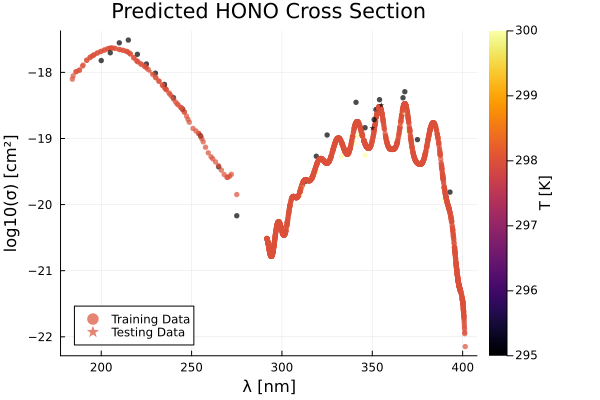

In [22]:
p1 = scatter(
    Xtrain.λ,
    y_pred_train,
    zcolor=Xtrain.T,
    ms=3, 
    msw=0,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    label="Training Data",
)

scatter!(
    Xtest.λ,
    y_pred_test,
    zcolor=Xtest.T,
    ms=3, 
    msw=0,
    # markershape=:rect,
    markershape=:star5,
    xlabel="λ [$(λ_units)]",
    ylabel="log10(σ) [cm²]",
    alpha=0.7,
    rightmargin=10Plots.mm,
    colorbar_title="T [$(T_units)]",
    title="Predicted $(nice_name) Cross Section",
    label="Testing Data",
)

194.249
401.4227


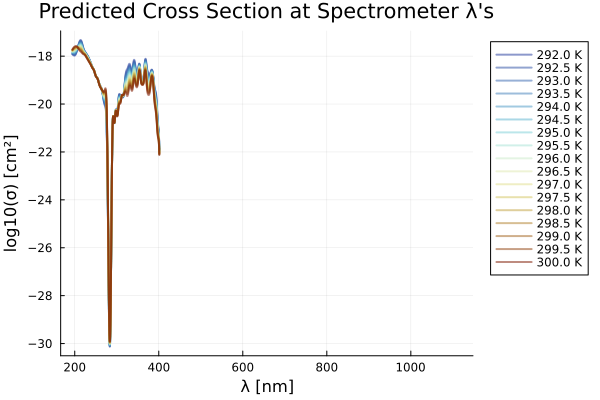

In [23]:
λ_min = maximum([min_data_λ, minimum(hr4000_df.λ)])
λ_max = minimum([max_data_λ, maximum(hr4000_df.λ)])

println(λ_min)
println(λ_max)

p = plot()

Ts = 292.0:0.5:300.0
# cs = cgrad(:thermal, Ts, categorical = true)
cs = cgrad(:roma, size(Ts,1), categorical = true, rev=true)
i = 1
for T ∈ Ts
    logσ = predict_logσ(T, hr4000_df, mach, (λ_min, λ_max))
    plot!(
        hr4000_df.λ, logσ,
        linewidth=2,
        alpha=0.5,
        color=cs[i],
        label="$(T) K",
        legend=:outertopright,
    )
    i+=1
end

xlabel!("λ [nm]")
ylabel!("log10(σ) [cm²]")
title!("Predicted Cross Section at Spectrometer λ's")

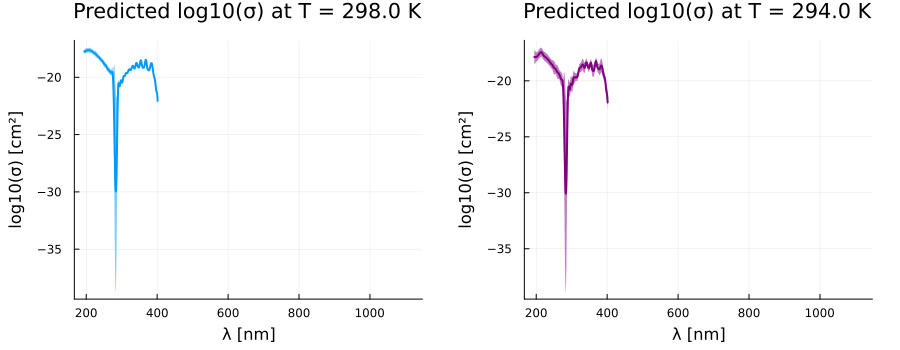

In [24]:
Tplot = 298.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

p1 = plot(
    hr4000_df.λ, logσ,
    ribbon= 2 .* Δlogσ,
    fillalpha=0.5,
    linewidth=2,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label="",
)

Tplot = 294.0
logσ, Δlogσ = predict_logσ_wΔ(Tplot, hr4000_df, mach, (λ_min, λ_max))

p2 = plot(
    hr4000_df.λ, logσ,
    ribbon= 2 .* Δlogσ,
    fillalpha=0.5,
    linewidth=2,
    color=:purple,
    xlabel="λ [nm]",
    ylabel="log10(σ) [cm²]",
    title="Predicted log10(σ) at T = $(Tplot) K",
    label=""
)

plot(p1, p2, layout=(1,2), margin=5Plots.mm, size=(900,350)) 